# Graph Convolution Network

*Graph Convolution Network (GCN)* architecture is the blueprint of what a GNN looks like.

(Ref. Kipf and Welling in 2017), it is based on the idea of creating an efficient variant of Convolution Neural Networks (CNNs) applied to graphs.

More accurately, it is an approximation of a graph convolution operation in graph signal processing.

More generally, it is the architecture of choice to create a solid baseline when dealing with graph data.

---

"We use the degree matrix to Normalize how to calculate embeddings for a node."

In [1]:
import numpy as np

D = np.array([[3, 0, 0, 0], [0, 1, 0, 0], [0, 0, 2, 0], [0, 0, 0, 2]]) # D matrix -> degree matrix counts the number of neighbours for each node.

D # D gives us the degree of each node, deg(i). Therefore, the inverse of this Matrix D^-1 directly gives us the normalization coefficients 1/deg(i)

array([[3, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 2, 0],
       [0, 0, 0, 2]])

In [2]:
D_inv = np.linalg.inv(D)

D_inv

# We should add self loops to the degree matrix : D` = D + I

# The final matrix we are actually interested in D`^-1 = (D+I)^-1

array([[0.33333333, 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.5       , 0.        ],
       [0.        , 0.        , 0.        , 0.5       ]])

In [3]:
D_tilda_inv = np.linalg.inv(D + np.identity(4))

D_tilda_inv

array([[0.25      , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.        , 0.33333333]])

- $ \tilde{D^{-1}} \tilde{A} X W^{T} $ will normalize every row of features

- $  \tilde{A} \tilde{D^{-1}} X W^{T} $ will normalize every column of features

In [4]:
A = np.array([[1, 1, 1, 1], [1, 1, 0, 0], [1, 0, 1, 1], [1, 0, 1, 1]])

print(np.linalg.inv(D + np.identity(4)) @ A)
print("\n")
print(A @ np.linalg.inv(D + np.identity(4)))

[[0.25       0.25       0.25       0.25      ]
 [0.5        0.5        0.         0.        ]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.33333333 0.         0.33333333 0.33333333]]


[[0.25       0.5        0.33333333 0.33333333]
 [0.25       0.5        0.         0.        ]
 [0.25       0.         0.33333333 0.33333333]
 [0.25       0.         0.33333333 0.33333333]]


The first option looks more appealing because it nicely normalizes neighboring (row) node features and not the single (column) feature

However, Kipf and Welling noticed that features from nodes with a lot of neighbors spread very easily, unlike features from more isolated nodes. In the original GCN paper, the authors proposed a hybrid normalization to counterbalance this effect. In practice, they assign higher weights to nodes with few neighbors using the following formula:

$$ H = \tilde{D}^{-1/2} \tilde{A}^{T} \tilde{D}^{-1/2} X W^{T}$$

In terms of individual embeddings, this operation can be written as follows:

$ h_{i} = \sum_{j \in N_{i}} \frac{1}{\sqrt[]{deg(i)}} \frac{1}{\sqrt[]{deg(j)}} x_{j} W^{T} $

Those are the original formulas to implement a graph convolutional layer. As with our Vanilla GNN layer, we can stack these layers to create a GCN.

## Implementing GCN

Compared to the Vanilla GNN, the main feature of the GCN is that it considers node degrees to weigh its features. let's analyze the node degrees in both (Cora and Facebook Page-Page Datasets).

(Directly Linked to the performance of the GCN)

From what we know about this architecture, we expect it to perform better when node degrees vary greatly. If every node has the same number of neighbors, these architecture are equivalent:

$$ \sqrt[]{deg(i)} \sqrt[]{deg(i)} = deg(i)$$

In [5]:
from torch_geometric.datasets import Planetoid # Importing Planetoid class from PyTorch Geometric

from torch_geometric.utils import degree

from collections import Counter

import matplotlib.pyplot as plt

In [6]:
dataset = Planetoid(root = ".", name = "Cora") # Cora dataset is imported and it's graph is stored in data
data = dataset[0]


In [7]:
degrees = degree(data.edge_index[0]).numpy() # number of neighbors of each node in the graph

In [8]:
numbers = Counter(degrees) # counting the number of nodes of each degree

<BarContainer object of 37 artists>

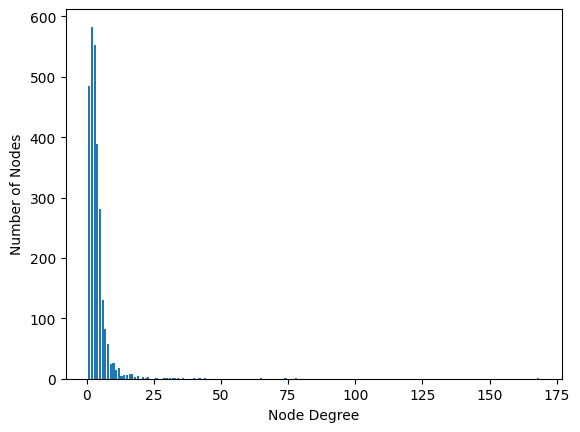

In [9]:
fig, ax = plt.subplots()
ax.set_xlabel('Node Degree')
ax.set_ylabel('Number of Nodes')

plt.bar(numbers.keys(), numbers.values()) # Number of Nodes with Specific Degrees in the Cora Dataset

This distribution looks exponential with a heavy tail: it ranges from 1 neighbor (485 nodes) to 168 
neighbors (1 node)! This is exactly the kind of dataset where we want a normalization process to
consider this disbalan.

Now we try to observe similar indications from the Facebook PagePage datasetce

<BarContainer object of 233 artists>

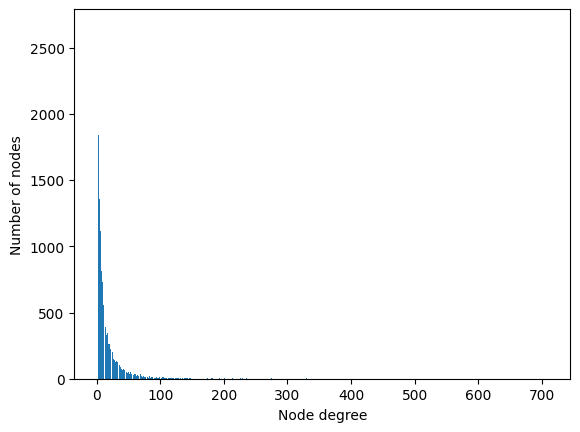

In [10]:
from torch_geometric.datasets import FacebookPagePage

# Import dataset from PyTorch Geometric
dataset = FacebookPagePage(root=".")
data = dataset[0]

# Create masks
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

We have estabished why we need GCN which are better for dealing with datasets with such skewed distribution of Node Degrees

In [11]:
# Implementation

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

In [12]:
def accuracy(pred_y, y):
 return ((pred_y == y).sum() / len(y)).item()


In [13]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim = 1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                     lr = 0.01,
                                     weight_decay=5e-4)

        self.train()
        for epoch in range(epochs + 1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim = 1), data.y[data.train_mask])

            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim = 1),
                                   data.y[data.val_mask])
                print(f'Epoch {epoch: >3} | Train Loss : {loss: 3f} | Train Acc:'
                      f' {acc*100 : >5.2f}% | Val Loss: {val_loss: .2f} | '
                f'Val Acc: {val_acc*100: .2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim = 1)[data.test_mask], data.y[data.test_mask])
        return acc


# Create the Vanilla GNN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train
gcn.fit(data, epochs=100)

# Test
acc = gcn.test(data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)
Epoch   0 | Train Loss :  1.957679 | Train Acc: 10.71% | Val Loss:  1.94 | Val Acc:  16.60%
Epoch  20 | Train Loss :  0.111018 | Train Acc: 99.29% | Val Loss:  0.80 | Val Acc:  78.00%
Epoch  40 | Train Loss :  0.015295 | Train Acc: 100.00% | Val Loss:  0.76 | Val Acc:  77.20%
Epoch  60 | Train Loss :  0.014098 | Train Acc: 100.00% | Val Loss:  0.74 | Val Acc:  78.00%
Epoch  80 | Train Loss :  0.016527 | Train Acc: 100.00% | Val Loss:  0.73 | Val Acc:  77.40%
Epoch 100 | Train Loss :  0.015466 | Train Acc: 100.00% | Val Loss:  0.73 | Val Acc:  77.20%

GCN test accuracy: 79.60%



In [14]:
# Load Facebook Page-Page
dataset = FacebookPagePage(root=".")
data = dataset[0]
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

# Train GCN
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)
gcn.fit(data, epochs=100)
acc = gcn.test(data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(128, 16)
  (gcn2): GCNConv(16, 4)
)
Epoch   0 | Train Loss :  1.566475 | Train Acc: 20.26% | Val Loss:  1.55 | Val Acc:  20.91%
Epoch  20 | Train Loss :  0.473839 | Train Acc: 84.01% | Val Loss:  0.46 | Val Acc:  85.14%
Epoch  40 | Train Loss :  0.327671 | Train Acc: 89.41% | Val Loss:  0.32 | Val Acc:  89.84%
Epoch  60 | Train Loss :  0.279295 | Train Acc: 91.32% | Val Loss:  0.27 | Val Acc:  91.95%
Epoch  80 | Train Loss :  0.254434 | Train Acc: 92.28% | Val Loss:  0.26 | Val Acc:  92.65%
Epoch 100 | Train Loss :  0.238537 | Train Acc: 92.81% | Val Loss:  0.24 | Val Acc:  92.90%

GCN test accuracy: 91.66%



In [15]:
from torch_geometric.datasets import WikipediaNetwork
import torch_geometric.transforms as T

dataset = WikipediaNetwork(root=".", name="chameleon", transform = T.RandomNodeSplit(num_val=200, num_test=500))
data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of unique features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: WikipediaNetwork()
-------------------
Number of graphs: 1
Number of nodes: 2277
Number of unique features: 2325
Number of classes: 5

Graph:
------
Edges are directed: True
Graph has isolated nodes: False
Graph has loops: True


In [16]:
from torch_geometric.datasets import WikipediaNetwork
import torch_geometric.transforms as T
dataset = WikipediaNetwork(root=".", name="chameleon", 
transform = T.RandomNodeSplit(num_val=200, num_test=500))
data = dataset[0]

print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of unique features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: WikipediaNetwork()
-------------------
Number of graphs: 1
Number of nodes: 2277
Number of unique features: 2325
Number of classes: 5


In [18]:
import pandas as pd
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

url = 'https://snap.stanford.edu/data/wikipedia.zip'
with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('.')
df = pd.read_csv('wikipedia/chameleon/musae_chameleon_target.csv')
values = np.log10(df['target'])
data.y = torch.tensor(values)
data.y

IncompleteRead: IncompleteRead(98304 bytes read, 3685851 more expected)

In [ ]:
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

In [ ]:
import seaborn as sns
from scipy.stats import norm

df['target'] = values
fig = sns.distplot(df['target'], fit=norm)

In [ ]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h*4)
        self.gcn2 = GCNConv(dim_h*4, dim_h*2)
        self.gcn3 = GCNConv(dim_h*2, dim_h)
        self.linear = torch.nn.Linear(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn3(h, edge_index)
        h = torch.relu(h)
        h = self.linear(h)
        return h

    def fit(self, data, epochs): 
        optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.02,
                                      weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = F.mse_loss(out.squeeze()[data.train_mask], data.y[data.train_mask].float())
            loss.backward()
            optimizer.step()
            if epoch % 20 == 0:
                val_loss = F.mse_loss(out.squeeze()[data.val_mask], data.y[data.val_mask])
                print(f"Epoch {epoch:>3} | Train Loss: {loss:.5f} | Val Loss: {val_loss:.5f}")

    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        return F.mse_loss(out.squeeze()[data.test_mask], data.y[data.test_mask].float())

# Create the Vanilla GNN model
gcn = GCN(dataset.num_features, 128, 1)
print(gcn) 

# Train
gcn.fit(data, epochs=200)

# Test
loss = gcn.test(data)
print(f'\nGCN test loss: {loss:.5f}\n')

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

out = gcn(data.x, data.edge_index)
y_pred = out.squeeze()[data.test_mask].detach().numpy()
mse = mean_squared_error(data.y[data.test_mask], y_pred)
mae = mean_absolute_error(data.y[data.test_mask], y_pred)

print('=' * 43)
print(f'MSE = {mse:.4f} | RMSE = {np.sqrt(mse):.4f} | MAE = {mae:.4f}')
print('=' * 43)

In [ ]:
fig = sns.regplot(x=data.y[data.test_mask].numpy(), y=y_pred)
fig.set(xlabel='Ground truth', ylabel='Predicted values')